# Shared Experiment Analysis

Things this notebook does:

- Creates shared plots that look better and use shared legend
- Creates plot which shows average normalized performance across environments.

In [1]:
import copy
import os.path as osp
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import posggym_agents

import baposgmcp.plot as plot_utils
import baposgmcp.plot.paper as paper_utils
from baposgmcp.config import BASE_REPO_DIR

TINY_SIZE = 10
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TINY_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=TINY_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# For UAI paper formatting
PAGE_WIDTH = 6.75  # inches
PAGE_COL_WIDTH = (6.75 - 0.25) / 2

algname = "POTMMCP"
baselinealgname = "I-POMCP-PF"

BASE_EXP_DIR = osp.join(BASE_REPO_DIR, "experiments")
BASE_AGENT_DIR = osp.join(posggym_agents.config.BASE_DIR, 'agents')

ENVS = {
    "Driving14x14WideRoundAbout-n2-v0" : osp.join(
            BASE_AGENT_DIR, "driving14x14wideroundabout_n2_v0", "results", "klrbr_results.csv"
    ),        
    "PursuitEvasion16x16-v0": osp.join(
        BASE_AGENT_DIR, "pursuitevasion16x16_v0", "results", "pairwise_results.csv"
    ),
    "PredatorPrey10x10-P2-p3-s2-coop-v0": osp.join(
        BASE_AGENT_DIR, "predatorprey10x10_P2_p3_s2_coop_v0", "results", "pairwise_results.csv"
    ),
    "PredatorPrey10x10-P4-p3-s3-coop-v0": osp.join(
        BASE_AGENT_DIR, "predatorprey10x10_P4_p3_s3_coop_v0", "results", "pairwise_results.csv"
    )
}

sims_result_files = {
    env_id: osp.join(BASE_EXP_DIR, env_id, "results", "sims_expected_performance_results.csv")
    for env_id in ENVS
}
time_result_files = {
    env_id: osp.join(BASE_EXP_DIR, env_id, "results", "time_expected_performance_results.csv")
    for env_id in ENVS
}

figure_dir = osp.join(BASE_EXP_DIR, "shared_figures")

print("Sim result files:")
for k, v in sims_result_files.items():
    print(" ", k, v)
    
print("\nTime result files:")
for k, v in time_result_files.items():
    print(" ", k, v)

Sim result files:
  Driving14x14WideRoundAbout-n2-v0 /home/jonathon/code/ba-posgmcp/experiments/Driving14x14WideRoundAbout-n2-v0/results/sims_expected_performance_results.csv
  PursuitEvasion16x16-v0 /home/jonathon/code/ba-posgmcp/experiments/PursuitEvasion16x16-v0/results/sims_expected_performance_results.csv
  PredatorPrey10x10-P2-p3-s2-coop-v0 /home/jonathon/code/ba-posgmcp/experiments/PredatorPrey10x10-P2-p3-s2-coop-v0/results/sims_expected_performance_results.csv
  PredatorPrey10x10-P4-p3-s3-coop-v0 /home/jonathon/code/ba-posgmcp/experiments/PredatorPrey10x10-P4-p3-s3-coop-v0/results/sims_expected_performance_results.csv

Time result files:
  Driving14x14WideRoundAbout-n2-v0 /home/jonathon/code/ba-posgmcp/experiments/Driving14x14WideRoundAbout-n2-v0/results/time_expected_performance_results.csv
  PursuitEvasion16x16-v0 /home/jonathon/code/ba-posgmcp/experiments/PursuitEvasion16x16-v0/results/time_expected_performance_results.csv
  PredatorPrey10x10-P2-p3-s2-coop-v0 /home/jonathon/

## Load Results

In [2]:
sims_exp_dfs = {env_id: pd.read_csv(fpath) for env_id, fpath in sims_result_files.items()}
time_exp_dfs = {env_id: pd.read_csv(fpath) for env_id, fpath in time_result_files.items()}

## Normalized Meta-Policy Performance

Performance of POTMMCP with each meta-policy, averaged across environments.

In [3]:
def normalize(x, min_x, max_x, a, b):
    # https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
    return (b-a)*((x-min_x)/(max_x - min_x)) + a


def add_normalized_return(row, return_bounds):
    n = row["num_sims"]
    min_x, max_x = return_bounds[n]
    return normalize(row["episode_return_mean"], min_x, max_x, 0, 1)


def add_normalized_CI(row, return_bounds):
    # this is definitely wrong
    min_x, max_x = return_bounds[row["num_sims"]]
    ci = row["episode_return_CI"]
    upper_ci = row["episode_return_mean"] + ci
    normalized_upper_ci = normalize(upper_ci, min_x, max_x, 0, 1)
    normalized_ci = normalized_upper_ci - row["normalized_episode_return_mean"]
    return normalized_ci


def add_standardized_return(row, return_means):
    n = row["num_sims"]
    return (row["episode_return_mean"] - return_means[n]) / row["episode_return_std"]


def add_standardized_CI(row):
    std = 1.0
    n = row["num_episodes"]
    return 1.96 * (std / np.sqrt(n))


def get_meta_pi_df(df):
    df = df[(df["alg_id"] == "baposgmcp") & (df["truncated"] == True)]
    
    num_sims = df["num_sims"].unique().tolist()
    num_sims.sort()
    
    meta_pis = df["meta_pi"].unique().tolist()
    meta_pis.sort()
    
    return_bounds = {}
    return_means = {}
    for n in num_sims:
        n_df = df[df["num_sims"] == n]
        print(
            n, 
            "\n ",  
            n_df["episode_return_mean"].tolist(), 
            "\n ", 
            n_df["episode_return_CI"].tolist()
        )
        return_bounds[n] = (
            (n_df["episode_return_mean"] - n_df["episode_return_CI"]).min(), 
            (n_df["episode_return_mean"] + n_df["episode_return_CI"]).max(), 
        )
        # return_means[n] = n_df["episode_return_mean"].mean()
        return_means[n] = df["episode_return_mean"].mean()
        
    pprint(return_bounds)
    pprint(return_means)
    
    # df["normalized_episode_return_mean"] = df.apply(
    #     lambda row: add_normalized_return(row, return_bounds), axis=1
    # )
    # df["normalized_episode_return_CI"] = df.apply(
    #     lambda row: add_normalized_CI(row, return_bounds), axis=1
    # )
    df["standardized_episode_return_mean"] = df.apply(
        lambda row: add_standardized_return(row, return_means), axis=1
    )
    df["standardized_episode_return_CI"] = df.apply(
        lambda row: add_standardized_CI(row), axis=1
    )
    
    
    for n in num_sims:
        n_df = df[df["num_sims"] == n]
        print(
            n, 
            "\n ",  
            n_df["standardized_episode_return_mean"].tolist(), 
            "\n ", 
            n_df["standardized_episode_return_CI"].tolist()
        )
        
    return df


def remove_agent_id(row):
    pi_id = row["policy_id"]
    tokens = pi_id.split("_")
    id_token = [t for t in tokens if t.startswith("i")][0]
    tokens.remove(id_token)
    return "_".join(tokens)


sims_meta_pi_dfs = []
for env_id, env_df in sims_exp_dfs.items():
    print(env_id)
    if env_id == "PursuitEvasion16x16-v0":
        # Add seperate DFs for each agent
        for agent_id in env_df["agent_id"].unique():
            agent_df = env_df[env_df["agent_id"] == agent_id]
            agent_df["policy_id"] = agent_df.apply(remove_agent_id, axis=1)
            sims_meta_pi_dfs.append(get_meta_pi_df(agent_df))
    else:
        sims_meta_pi_dfs.append(get_meta_pi_df(env_df))

Driving14x14WideRoundAbout-n2-v0
10 
  [1.6672916666666668, 1.712791666666667, 1.7146250000000005] 
  [0.1098668528125979, 0.1078075721269492, 0.1074239844171932]
50 
  [2.059541666666667, 2.079708333333333, 2.0507500000000003] 
  [0.0644601790705143, 0.0628805123364734, 0.0668460399107073]
100 
  [2.105541666666667, 2.1195416666666667, 2.1016250000000003] 
  [0.0522049393077709, 0.0532851938497462, 0.058557542773162]
500 
  [2.170583333333334, 2.185708333333334, 2.174458333333334] 
  [0.0360427137727321, 0.025501595160549, 0.0350668000412989]
1000 
  [2.171252066526457, 2.198404864191734, 2.182111926396571] 
  [0.0380373902545657, 0.0219910717450315, 0.0286416675065576]
{10: (1.557424813854069, 1.8220489844171937),
 50: (1.983903960089293, 2.1425888456698066),
 100: (2.0430674572268384, 2.172826860516413),
 500: (2.134540619560602, 2.211209928493883),
 1000: (2.1332146762718915, 2.2203959359367658)}
{10: 2.0462623682520955,
 50: 2.0462623682520955,
 100: 2.0462623682520955,
 500: 2.04

/tmp/ipykernel_1359938/1056970425.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["standardized_episode_return_mean"] = df.apply(
/tmp/ipykernel_1359938/1056970425.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["standardized_episode_return_CI"] = df.apply(
/tmp/ipykernel_1359938/1056970425.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [4]:
meta_pi_label_map = {
    "greedy": r"$\sigma^{G}$",
    "softmax": r"$\sigma^{S}$",
    "uniform": r"$\sigma^{U}$",
}

meta_pi_df = pd.concat(sims_meta_pi_dfs)

meta_alg_ids = meta_pi_df["alg_id"].unique().tolist()
meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_alg_ids:
    print(n)
    
policy_ids = meta_pi_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)
    
agg_dict = plot_utils.get_uniform_expected_agg_map(meta_pi_df)
gb = meta_pi_df.groupby(["policy_id"])
gb_agg = gb.agg(**agg_dict)

print("Ungrouped size =", len(meta_pi_df))
meta_pi_exp_df = gb_agg.reset_index()
print("Grouped size =", len(meta_pi_exp_df ))

new_policies = set(meta_pi_exp_df ["policy_id"].unique().tolist())
assert len(new_policies) == len(meta_pi_exp_df ), "Should be one row per policy ID"

Alg IDs
-------
baposgmcp

Policy IDs
----------
baposgmcp_metagreedy_numsims1000_truncatedTrue
baposgmcp_metagreedy_numsims100_truncatedTrue
baposgmcp_metagreedy_numsims10_truncatedTrue
baposgmcp_metagreedy_numsims500_truncatedTrue
baposgmcp_metagreedy_numsims50_truncatedTrue
baposgmcp_metasoftmax_numsims1000_truncatedTrue
baposgmcp_metasoftmax_numsims100_truncatedTrue
baposgmcp_metasoftmax_numsims10_truncatedTrue
baposgmcp_metasoftmax_numsims500_truncatedTrue
baposgmcp_metasoftmax_numsims50_truncatedTrue
baposgmcp_metauniform_numsims1000_truncatedTrue
baposgmcp_metauniform_numsims100_truncatedTrue
baposgmcp_metauniform_numsims10_truncatedTrue
baposgmcp_metauniform_numsims500_truncatedTrue
baposgmcp_metauniform_numsims50_truncatedTrue
Ungrouped size = 75
Grouped size = 15


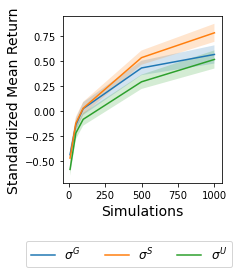

In [5]:
fig_kwargs = {"figsize": (PAGE_COL_WIDTH, 3.7)}
subplot_kwargs = {
    "ylabel": "Standardized Mean Return",
    "xlabel": "Simulations"
}

num_rows = 1
num_cols = 1
fig, ax = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=True,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

plot_utils.paper.plot_meta_policy_vs_num_sims(
    meta_pi_exp_df,
    ax,
    y_key="standardized_episode_return_mean",
    y_err_key="standardized_episode_return_CI",
    meta_pi_label_map=meta_pi_label_map,
    alg_id_key="alg_id",
)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, loc="lower right")

fig.tight_layout(rect=(0.0, 0.16, 1.0, 1.0))
fig.savefig(osp.join(figure_dir, f"shared_meta_pi_standardize_return.png"))


## Baseline performance vs search time

In [20]:
def remove_agent_id(row):
    pi_id = row["policy_id"]
    tokens = pi_id.split("_")
    id_token = [t for t in tokens if t.startswith("i")][0]
    tokens.remove(id_token)
    return "_".join(tokens)


env_labels = {
    "Driving14x14WideRoundAbout-n2-v0": "Driving",
    "PursuitEvasion16x16-v0": {
        0: "PE (Evader)",
        1: "PE (Pursuer)"
    },
    "PredatorPrey10x10-P2-p3-s2-coop-v0": "PP (two-agents)",
    "PredatorPrey10x10-P4-p3-s3-coop-v0": "PP (four-agents)"
    
}

time_baseline_dfs = {}
for env_id, fpath in time_result_files.items():
    env_df = pd.read_csv(fpath)
    env_label = env_labels[env_id]
    print(env_id)
    if env_id == "PursuitEvasion16x16-v0":
        # Add seperate DFs for each agent
        for agent_id in env_df["agent_id"].unique():
            agent_df = env_df[env_df["agent_id"] == agent_id]
            agent_df["policy_id"] = agent_df.apply(remove_agent_id, axis=1)
            time_baseline_dfs[env_label[agent_id]] = agent_df
    else:
        time_baseline_dfs[env_label] = env_df

def get_df_info(df):
    alg_ids = df["alg_id"].unique().tolist()
    alg_ids.sort()
    print("Alg IDs")
    print("-------")
    for n in alg_ids:
        print(n)

    policy_ids = df["policy_id"].unique().tolist()
    policy_ids.sort()
    print("\nPolicy IDs")
    print("----------")
    for n in policy_ids:
        print(n)
        

for env_label, env_df in time_baseline_dfs.items():
    print("\n##########")
    print(env_label)
    print("##########")
    get_df_info(env_df)

Driving14x14WideRoundAbout-n2-v0
PursuitEvasion16x16-v0
PredatorPrey10x10-P2-p3-s2-coop-v0
PredatorPrey10x10-P4-p3-s3-coop-v0

##########
Driving
##########
Alg IDs
-------
baposgmcp
baposgmcp-random
fixed
full-knowledge-br
metabaseline
ucbmcp
ucbmcp-random

Policy IDs
----------
baposgmcp-random_searchtimelimit0.1_truncatedFalse
baposgmcp-random_searchtimelimit10_truncatedFalse
baposgmcp-random_searchtimelimit1_truncatedFalse
baposgmcp-random_searchtimelimit20_truncatedFalse
baposgmcp-random_searchtimelimit5_truncatedFalse
baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue
full-knowledge-br
klr_k0_seed0-v0
klr_k1_seed0-v0
klr_k2_seed0-v0
klr_k3_seed0-v0
klr_k4_seed0-v0
metabaseline_softmax
ucbmcp-random_searchtimelimit0.1_truncatedFalse
ucbmcp-random_searchtimelimit10_tr

/tmp/ipykernel_1359938/1306933841.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agent_df["policy_id"] = agent_df.apply(remove_agent_id, axis=1)
/tmp/ipykernel_1359938/1306933841.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agent_df["policy_id"] = agent_df.apply(remove_agent_id, axis=1)


Driving
PE (Evader)
PE (Pursuer)
PP (two-agents)
PP (four-agents)


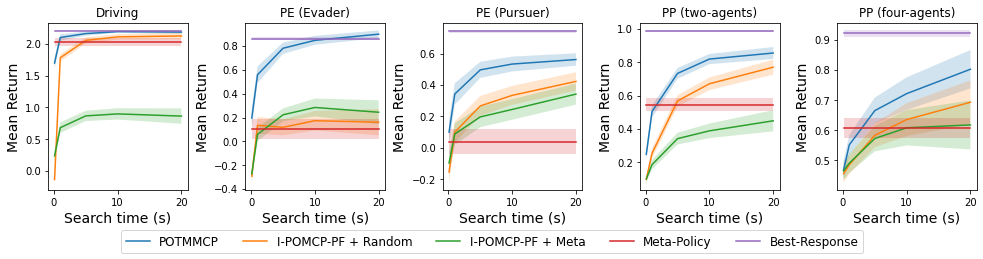

In [21]:
best_meta_pi = "softmax"

time_baseline_policy_prefixes_to_plot = [
    f"baposgmcp_meta{best_meta_pi}",
    # "baposgmcp-random",
    "ucbmcp-random",
    f"ucbmcp_meta{best_meta_pi}",
    f"metabaseline_{best_meta_pi}",
    f"full-knowledge-br",   
]
constant_policy_prefixes = [
    f"metabaseline_{best_meta_pi}",
    f"full-knowledge-br",
]

time_baseline_pi_label_map = {
    f"baposgmcp_meta{best_meta_pi}": algname,
    # "baposgmcp-random": f"{algname} + Random", 
    "full-knowledge-br": "Best-Response",
    f"metabaseline_{best_meta_pi}": "Meta-Policy",
    f"ucbmcp_meta{best_meta_pi}": f"{baselinealgname} + Meta",
    "ucbmcp-random": f"{baselinealgname} + Random"
}

fig_kwargs = {"figsize": (PAGE_WIDTH*2, 3.5)}
subplot_kwargs = {
    "ylabel": "Mean Return",
    "xlabel": "Search time (s)"
}


num_rows = 1
num_cols = len(time_baseline_dfs)

fig, axs = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=False,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

for i, (env_label, env_df) in enumerate(time_baseline_dfs.items()):
    print(env_label)
    ax = axs[0][i]
    plot_utils.paper.plot_performance(
        env_df,
        ax=ax,
        x_key="search_time_limit",
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        policy_key="policy_id",
        policy_prefixes=time_baseline_policy_prefixes_to_plot,
        constant_policy_prefixes=constant_policy_prefixes,
        pi_label_map=time_baseline_pi_label_map,
    )
    ax.set_title(env_label)
    
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=5, loc="lower center")

fig.tight_layout(pad=0.1, w_pad=0.8, h_pad=1.0, rect=(0.0, 0.125, 1.0, 1.0))
fig.savefig(osp.join(figure_dir, "shared_baselines_return_vs_search_time.png"))

# Standardized Meta-policy vs fixed policy performance

In [22]:
meta_fixed_env_label_map = {
    "Driving14x14WideRoundAbout-n2-v0": {
        "baposgmcp_metasoftmax": r"$\sigma^{S}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_piklrk0seed0-v0": "Worst", 
        # "baposgmcp-fixed_piklrk1seed0-v0": "K1", 
        "baposgmcp-fixed_piklrk2seed0-v0": "Best",
        # "baposgmcp-fixed_piklrk3seed0-v0": "K3",
        # "baposgmcp-fixed_piklrk4seed0-v0": "K4"
    },
    "PursuitEvasion16x16-v0": {
        0: {
            "baposgmcp_metasoftmax": r"$\sigma^{S}$",
            "baposgmcp-random": "Random",
            "baposgmcp-fixed_piklrk0seed0i0-v0": "Worst",
            #"baposgmcp-fixed_i0_piklrk1seed0i0-v0": "K1_0",
            "baposgmcp-fixed_piklrk2seed0i0-v0": "Best",
            # "baposgmcp-fixed_i0_piklrk3seed0i0-v0": "K3_0",
        },
        1: {
            "baposgmcp_metasoftmax": r"$\sigma^{S}$",
            "baposgmcp-random": "Random",
            "baposgmcp-fixed_piklrk0seed0i1-v0": "Worst",
            # "baposgmcp-fixed_i1_piklrk1seed0i1-v0": "K1_1",
            "baposgmcp-fixed_piklrk2seed0i1-v0": "Best",
            # "baposgmcp-fixed_piklrk3seed0i1-v0": "K3_1",
        }
    },
    "PredatorPrey10x10-P2-p3-s2-coop-v0": {
        "baposgmcp_metasoftmax": r"$\sigma^{S}$",
        "baposgmcp-random": "Random",
        # "baposgmcp_fixed_pispseed0-v0": "S0",
        "baposgmcp-fixed_pispseed1-v0": "Worst",
        # "baposgmcp_fixed_pispseed2-v0": "S2",
        # "baposgmcp_fixed_pispseed3-v0": "S3",
        "baposgmcp-fixed_pispseed4-v0": "Best",
    }, 
    "PredatorPrey10x10-P4-p3-s3-coop-v0": {
        "baposgmcp_metasoftmax": r"$\sigma^{S}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_pispseed0-v0": "Worst", 
        "baposgmcp-fixed_pispseed1-v0": "Best", 
        # "baposgmcp-fixed_pispseed2-v0": "S2",
        # "baposgmcp-fixed_pispseed3-v0": "S3",
        # "baposgmcp-fixed_pispseed4-v0": "S4"
    }
    
}


def add_standardized_return(row, return_means):
    n = row["num_sims"]
    return (row["episode_return_mean"] - return_means[n]) / row["episode_return_std"]


def add_standardized_CI(row):
    std = 1.0
    n = row["num_episodes"]
    return 1.96 * (std / np.sqrt(n))


def get_meta_fixed_df(df, pi_map):
    best_fixed_pi_id_prefix = [k for k, v in pi_map.items() if v == "Best"][0]
    worst_fixed_pi_id_prefix = [k for k, v in pi_map.items() if v == "Worst"][0]
    
    df = df[
        ((df["alg_id"] == "baposgmcp") & (df["meta_pi"] == "softmax") & (df["truncated"] == True))
        | (
            (df["alg_id"] == "baposgmcp-fixed") 
            & (df["truncated"] == True)
            & (
                (df["policy_id"].str.startswith(best_fixed_pi_id_prefix))
                | (df["policy_id"].str.startswith(worst_fixed_pi_id_prefix))
            )
        )
        | ((df["alg_id"] == "baposgmcp-random") & (df["truncated"] == False))
    ]
    
    def replace_fixed_pi_id(row):
        pi_id = row["policy_id"]
        tokens = pi_id.split("_")
        if pi_id.startswith(best_fixed_pi_id_prefix):
            tokens[1] = "best"
        elif pi_id.startswith(worst_fixed_pi_id_prefix):
            tokens[1] = "worst"
        return "_".join(tokens)
            
    df["policy_id"] = df.apply(replace_fixed_pi_id, axis=1)
    
    num_sims = df["num_sims"].unique().tolist()
    num_sims.sort()
    
    return_means = {}
    for n in num_sims:
        n_df = df[df["num_sims"] == n]
        # return_means[n] = n_df["episode_return_mean"].mean()
        return_means[n] = df["episode_return_mean"].mean()
        
    pprint(return_means)
    pprint(df["policy_id"].unique().tolist())
    
    df["standardized_episode_return_mean"] = df.apply(
        lambda row: add_standardized_return(row, return_means), axis=1
    )
    df["standardized_episode_return_CI"] = df.apply(
        lambda row: add_standardized_CI(row), axis=1
    )
        
    return df


def remove_agent_id(row):
    pi_id = row["policy_id"]
    tokens = pi_id.split("_")
    id_token = [t for t in tokens if t.startswith("i")][0]
    tokens.remove(id_token)
    return "_".join(tokens)


sims_meta_fixed_dfs = []
for env_id, env_df in sims_exp_dfs.items():
    print("\n", env_id)
    env_pi_map = meta_fixed_env_label_map[env_id]
    if env_id == "PursuitEvasion16x16-v0":
        # Add seperate DFs for each agent
        for agent_id in env_df["agent_id"].unique():
            print(agent_id)
            agent_df = env_df[env_df["agent_id"] == agent_id]
            agent_df["policy_id"] = agent_df.apply(remove_agent_id, axis=1)
            sims_meta_fixed_dfs.append(get_meta_fixed_df(agent_df, env_pi_map[agent_id]))
    else:
        sims_meta_fixed_dfs.append(get_meta_fixed_df(env_df, env_pi_map))


 Driving14x14WideRoundAbout-n2-v0
{10: 1.9340953946912272,
 50: 1.9340953946912272,
 100: 1.9340953946912272,
 500: 1.9340953946912272,
 1000: 1.9340953946912272}
['baposgmcp-fixed_worst_numsims1000_truncatedTrue',
 'baposgmcp-fixed_worst_numsims100_truncatedTrue',
 'baposgmcp-fixed_worst_numsims10_truncatedTrue',
 'baposgmcp-fixed_worst_numsims500_truncatedTrue',
 'baposgmcp-fixed_worst_numsims50_truncatedTrue',
 'baposgmcp-fixed_best_numsims1000_truncatedTrue',
 'baposgmcp-fixed_best_numsims100_truncatedTrue',
 'baposgmcp-fixed_best_numsims10_truncatedTrue',
 'baposgmcp-fixed_best_numsims500_truncatedTrue',
 'baposgmcp-fixed_best_numsims50_truncatedTrue',
 'baposgmcp-random_numsims1000_truncatedFalse',
 'baposgmcp-random_numsims100_truncatedFalse',
 'baposgmcp-random_numsims10_truncatedFalse',
 'baposgmcp-random_numsims500_truncatedFalse',
 'baposgmcp-random_numsims50_truncatedFalse',
 'baposgmcp_metasoftmax_numsims1000_truncatedTrue',
 'baposgmcp_metasoftmax_numsims100_truncatedTru

/tmp/ipykernel_1359938/1840151549.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["policy_id"] = df.apply(replace_fixed_pi_id, axis=1)
/tmp/ipykernel_1359938/1840151549.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["standardized_episode_return_mean"] = df.apply(
/tmp/ipykernel_1359938/1840151549.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [23]:
meta_fixed_df = pd.concat(sims_meta_fixed_dfs)

meta_alg_ids = meta_fixed_df["alg_id"].unique().tolist()
meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_alg_ids:
    print(n)
    
policy_ids = meta_fixed_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)
    
agg_dict = plot_utils.get_uniform_expected_agg_map(meta_fixed_df)
gb = meta_fixed_df.groupby(["policy_id"])
gb_agg = gb.agg(**agg_dict)

print("Ungrouped size =", len(meta_fixed_df))
meta_fixed_exp_df = gb_agg.reset_index()
print("Grouped size =", len(meta_fixed_exp_df ))

new_policies = set(meta_fixed_exp_df ["policy_id"].unique().tolist())
assert len(new_policies) == len(meta_fixed_exp_df ), "Should be one row per policy ID"

Alg IDs
-------
baposgmcp
baposgmcp-fixed
baposgmcp-random

Policy IDs
----------
baposgmcp-fixed_best_numsims1000_truncatedTrue
baposgmcp-fixed_best_numsims100_truncatedTrue
baposgmcp-fixed_best_numsims10_truncatedTrue
baposgmcp-fixed_best_numsims500_truncatedTrue
baposgmcp-fixed_best_numsims50_truncatedTrue
baposgmcp-fixed_worst_numsims1000_truncatedTrue
baposgmcp-fixed_worst_numsims100_truncatedTrue
baposgmcp-fixed_worst_numsims10_truncatedTrue
baposgmcp-fixed_worst_numsims500_truncatedTrue
baposgmcp-fixed_worst_numsims50_truncatedTrue
baposgmcp-random_numsims1000_truncatedFalse
baposgmcp-random_numsims100_truncatedFalse
baposgmcp-random_numsims10_truncatedFalse
baposgmcp-random_numsims500_truncatedFalse
baposgmcp-random_numsims50_truncatedFalse
baposgmcp_metasoftmax_numsims1000_truncatedTrue
baposgmcp_metasoftmax_numsims100_truncatedTrue
baposgmcp_metasoftmax_numsims10_truncatedTrue
baposgmcp_metasoftmax_numsims500_truncatedTrue
baposgmcp_metasoftmax_numsims50_truncatedTrue
Ungroup

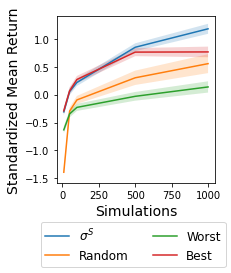

In [24]:
meta_fixed_label_map = {
    "baposgmcp_metasoftmax": r"$\sigma^{S}$",
    "baposgmcp-random": "Random",
    "baposgmcp-fixed_worst": "Worst", 
    "baposgmcp-fixed_best": "Best", 
}


fig_kwargs = {"figsize": (PAGE_COL_WIDTH, 3.7)}
subplot_kwargs = {
    "ylabel": "Standardized Mean Return",
    "xlabel": "Simulations"
}

num_rows = 1
num_cols = 1
fig, ax = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=True,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

plot_utils.paper.plot_performance(
    meta_fixed_exp_df,
    ax,
    x_key="num_sims",
    y_key="standardized_episode_return_mean",
    y_err_key="standardized_episode_return_CI",
    policy_prefixes=list(meta_fixed_label_map),
    pi_label_map=meta_fixed_label_map,
    constant_policy_prefixes=[],
    policy_key="policy_id",
)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc="lower right")

fig.tight_layout(rect=(0.0, 0.16, 1.0, 1.0))
fig.savefig(osp.join(figure_dir, f"shared_meta_fixed_standardize_return.png"))

# Search Depth

In [26]:
policy_prefixes_to_plot = [
    f"baposgmcp_meta{best_meta_pi}",
    "ucbmcp-random",
    f"ucbmcp_meta{best_meta_pi}"
]

baseline_pi_label_map = {
    f"baposgmcp_meta{best_meta_pi}": algname,
    f"ucbmcp_meta{best_meta_pi}": f"{baselinealgname} + Meta",
    "ucbmcp-random": f"{baselinealgname} + Random"
}



time_avg_dfs = []
for env_label, env_df in time_baseline_dfs.items():
    print(env_label)
    sub_df = env_df[
        ((env_df["alg_id"] == "baposgmcp") & (env_df["meta_pi"] == "softmax") & (env_df["truncated"] == True))
        | ((env_df["alg_id"] == "ucbmcp") & (env_df["meta_pi"] == "softmax") & (env_df["truncated"] == True))
        | ((env_df["alg_id"] == "ucbmcp-random") & (env_df["truncated"] == False))
    ]
    time_avg_dfs.append(sub_df)

time_avg_df = pd.concat(time_avg_dfs)
print()
get_df_info(time_avg_df)
    
agg_dict = plot_utils.get_uniform_expected_agg_map(time_avg_df)
gb = time_avg_df.groupby(["policy_id"])
gb_agg = gb.agg(**agg_dict)

print("Ungrouped size =", len(time_avg_df))
time_avg_exp_df = gb_agg.reset_index()
print("Grouped size =", len(time_avg_exp_df ))

new_policies = set(time_avg_exp_df ["policy_id"].unique().tolist())
assert len(new_policies) == len(time_avg_exp_df), "Should be one row per policy ID"

Driving
PE (Evader)
PE (Pursuer)
PP (two-agents)
PP (four-agents)

Alg IDs
-------
baposgmcp
ucbmcp
ucbmcp-random

Policy IDs
----------
baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue
ucbmcp-random_searchtimelimit0.1_truncatedFalse
ucbmcp-random_searchtimelimit10_truncatedFalse
ucbmcp-random_searchtimelimit1_truncatedFalse
ucbmcp-random_searchtimelimit20_truncatedFalse
ucbmcp-random_searchtimelimit5_truncatedFalse
ucbmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
ucbmcp_metasoftmax_searchtimelimit10_truncatedTrue
ucbmcp_metasoftmax_searchtimelimit1_truncatedTrue
ucbmcp_metasoftmax_searchtimelimit20_truncatedTrue
ucbmcp_metasoftmax_searchtimelimit5_truncatedTrue
Ungrouped size = 75
Grouped size = 15


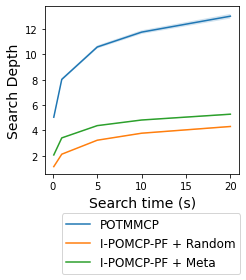

In [38]:
best_meta_pi = "softmax"

fig_kwargs = {"figsize": (PAGE_COL_WIDTH, 3.8)}
subplot_kwargs = {
    "ylabel": "Search Depth",
    "xlabel": "Search time (s)"
}

num_rows = 1
num_cols = 1

fig, ax = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=True,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

plot_utils.paper.plot_performance(
    time_avg_exp_df,
    ax=ax,
    x_key="search_time_limit",
    y_key="search_depth_mean",
    y_err_key="search_depth_CI",
    policy_key="policy_id",
    policy_prefixes=[
        f"baposgmcp_meta{best_meta_pi}",
        "ucbmcp-random",
        f"ucbmcp_meta{best_meta_pi}",
    ],
    constant_policy_prefixes=[],
    pi_label_map={
        f"baposgmcp_meta{best_meta_pi}": algname,
        # "baposgmcp-random": f"{algname} + Random", 
        f"ucbmcp_meta{best_meta_pi}": f"{baselinealgname} + Meta",
        "ucbmcp-random": f"{baselinealgname} + Random"
    },
)
# ax.legend()
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=1, loc="lower right")

fig.tight_layout(pad=0.1, w_pad=0.8, h_pad=1.0, rect=(0.0, 0.25, 1.0, 1.0))
# fig.savefig(osp.join(figure_dir, "shared_baselines_return_vs_search_time.png"))

del fig_kwargs
del subplot_kwargs